# Remastered Images

 Gabriel Moreira e Matheus Dias

## Introdução

O objetivo principal desse projeto de Machine Learning é restaurar imagens antigas para que fiquem com boa qualidade. Para isso, foi usado dois modelos diferentes: um deles é responsável por aumentar a resolução da imagem eo outro por colorir a imagens (uma vez que imagens antigas, em sua maioria, possuem apenas um canal de cor)

Por se tratar de imagens, foi usado modelos de redes neurais convolucionais em ambos casos. O dataset utilizado foi o Common Objects in Context (COCO)

link para dataset: http://images.cocodataset.org/zips/unlabeled2017.zip

#### Download do dataset (~20 GB)

In [1]:
#!wget http://images.cocodataset.org/zips/unlabeled2017.zip -O dataset

In [2]:
# !unzip dataset/

## Imports

In [29]:
%matplotlib inline
import cv2
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.utils import Sequence
from tensorflow import keras
from time import time
import matplotlib.pyplot as plt

In [4]:
def show(path):
    result = cv2.imread(path)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    plt.imshow(result)

## Aumento de resolução

### Preparação dos dados

Com a utilização de um generator, pode-se criar batches para o treinamento, o que torna possível o treinamento datasets maiores que o tamanho da memória RAM.

In [5]:
class Generator(Sequence):
    def __init__(self, imageX_filenames, batch_size):
        self.imageX_filenames = imageX_filenames
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.imageX_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.imageX_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        X = []
        Y = []
        for file_name_x in batch_x:
            image = cv2.imread(file_name_x) / 255.0
            try:
                image = image[image//2 - 128:image//2 + 128, image//2 - 128:image//2 + 128]
            except Exception as e:
                continue
            X.append(cv2.pyrDown(image))
            Y.append(image)

        return np.array(X), np.array(Y)

In [6]:
# path dos datasets
dataset_path = './dataset'

# path no qual o modelo será salvo
checkpoint_path = "./models/modelEnhanceNew/cp-{epoch:04d}.ckpt"

# número de imagens por batch
batch_size = 64

file_path = os.listdir(dataset_path)

complete_path = [os.path.join(dataset_path, image_path) for image_path in file_path]

# número de imagens por epoch
num_training_samples = 1024

# número de epochs
num_epochs = 6

# tamanho do dataset de validação
num_validation_samples = 200

X_train = complete_path[len(complete_path) - num_training_samples:]
X_test = complete_path[:num_validation_samples]

y_train = complete_path[len(complete_path) - num_training_samples:]
y_test = complete_path[:num_validation_samples]

### Modelo

In [7]:
def create_model_enhance(input_shape):
    model = keras.Sequential([
        keras.layers.UpSampling2D(size=2, input_shape=input_shape, data_format=None, interpolation='nearest'),
        keras.layers.Conv2D(32, (3,3), activation=tf.nn.relu, padding='same'),

        keras.layers.Conv2D(64, (3, 3), activation = tf.nn.relu, padding='same'),

        keras.layers.Conv2D(32, (3, 3), activation = tf.nn.relu, padding='same'),

        keras.layers.Conv2D(3, (3, 3), activation = tf.nn.relu, padding='same'),

    ])
    
    model.compile(optimizer='adam', 
              loss='mse',
              metrics=['accuracy'])
    
    return model

O modelo da rede neural para melhor a resolução da imagem usa muito o conceito de decoder, capaz de aumentar a quantidade de features de um dado específico. Neste caso, o objetivo é partir de uma pequena quantidade de features (uma imagem menor) para o dobro da quantidade de features (uma imagem com o dobro do tamanho)


<img src="./img/modelEnhance.jpeg">

### Treinamento

In [8]:
train = False

In [9]:

if train:
    #criação dos batches
    my_training_batch_generator = Generator(X_train, y_train, batch_size)
    my_validation_batch_generator = Generator(X_test, y_test, batch_size)

    # criação de um callback para que o modelo seja salvo a cada 3 epochs durante o treinamento
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, verbose=1, save_weights_only=True,
        period=3)

    # modelo é criado
    model = create_model_enhance((128, 128, 3))

    # treinamento do modelo usando batches
    model.fit_generator(generator=my_training_batch_generator,
                        steps_per_epoch=(num_training_samples // batch_size) ,
                        epochs=num_epochs,
                        validation_data=my_validation_batch_generator,
                        validation_steps=(num_validation_samples // batch_size),
                        callbacks = [cp_callback],
                        verbose=1)

### Resultados

In [10]:
def enhance(img, model_weigths_path):
    model = create_model_enhance(img.shape)
    model.load_weights(model_weigths_path)
    a = model.predict([[img]])
    return a[0]

In [11]:
# lê input
img = cv2.imread('./img/inputEnhance.jpg')
result = enhance(img, './models/model_enhance/')
cv2.imwrite('./img/outputEnhance.jpg', result)

True

#### Input

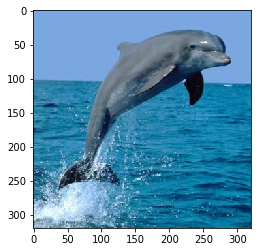

In [12]:
show("./img/inputEnhance.jpg")

#### Output

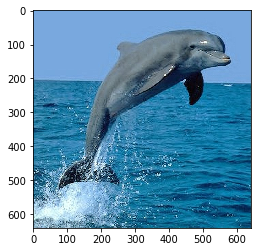

In [13]:
show("./img/outputEnhance.jpg")

## Colorização

### Preparação dos dados

Com a utilização de um objeto generator, pode-se criar batches para o treinamento, o que torna possível o treinamento de datasets maiores que o tamanho da memória RAM.
As imagens usadas no treinamento foram convertidas para o espaço de cor LAB, que possui três canais: 
* L - o canal de luz que basicamente é a imagem em preto e branco
* A - o primeiro canal de cor que varia de vermelho à verde
* B - o segundo canal de cor que varia de azul à amarelo

Desta forma, o input da rede neural é o canal L da imagem (ou seja, a própria em imagem preto e branco) e sua saída são os canais A e B (os canais que possuem cor). Por isso, a geração de cor na imagem fica mais fácil em relação ao espaço de cor RGB, uma vez que a rede deve prever apenas dois canais de cor ao invés de três.

<img src="./img/lab.jpg">
Exemplo do espaço de cor LAB

In [14]:
class Generator(Sequence):

    def __init__(self, imageY_filenames, batch_size):
        self.imageY_filenames = imageY_filenames
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.imageY_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_y = self.imageY_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X = []
        Y = []
        for file_name_y in batch_y:
            image = cv2.imread(file_name_y)
            try:
                image = image[image//2 - 128:image//2 + 128, image//2 - 128:image//2 + 128]
            except Exception as e:
                continue
            lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
            l = 2 * lab[:,:,:1] / 255.0 - 1.0
            ab = 2 * lab[:,:,1:] / 255.0 - 1.0
            X.append(l)
            Y.append(ab)

        return np.array(X), np.array(Y)

In [15]:
# path dos datasets
dataset_path = './dataset'

# path no qual o modelo será salvo
checkpoint_path = "./models/model_colorize_new/cp-{epoch:04d}.ckpt"

# número de imagens por batch
batch_size = 64

file_path = os.listdir(dataset_path)

complete_path = [os.path.join(dataset_path, image_path) for image_path in file_path]

# número de imagens por epoch
num_training_samples = 1024

# número de epochs
num_epochs = 6

# tamanho do dataset de validação
num_validation_samples = 200

X_train = complete_path[len(complete_path) - num_training_samples:]
X_test = complete_path[:num_validation_samples]

y_train = complete_path[len(complete_path) - num_training_samples:]
y_test = complete_path[:num_validation_samples]

### Modelo

In [16]:
def create_model_colorize(input_shape):
    model = keras.Sequential([
        keras.layers.Conv2D(64,(3, 3),input_shape=input_shape, padding='same', strides=2),
        keras.layers.Conv2D(128,(3, 3), activation = tf.nn.relu, padding='same',strides=2),
        keras.layers.Conv2D(256,(3, 3), activation = tf.nn.relu, padding='same', strides=2),
        keras.layers.UpSampling2D(size=2),
        keras.layers.Conv2D(512,(3, 3), activation = tf.nn.relu, padding='same'),
        keras.layers.Conv2D(512,(3, 3), activation = tf.nn.relu, padding='same'),
        keras.layers.Conv2D(512,(3, 3), activation = tf.nn.relu, padding='same'),
        keras.layers.Conv2D(512,(3, 3), activation = tf.nn.relu, padding='same'),
        keras.layers.Conv2D(512,(3, 3), activation = tf.nn.relu, padding='same'),
        keras.layers.Conv2D(256,(3, 3), activation = tf.nn.relu, padding='same'),
        keras.layers.UpSampling2D(size=2),
        keras.layers.Conv2D(128,(3, 3), activation = tf.nn.relu, padding='same'),
        keras.layers.UpSampling2D(size=2),
        keras.layers.Conv2D(64,(3, 3), activation = tf.nn.relu, padding='same'),
        keras.layers.Conv2D(2, (3, 3), activation = tf.nn.tanh, padding='same'),
    ])
    
    model.compile(optimizer='adam', loss='mse')
    return model

Arquitetura da rede neural

<img src="./img/modelColorizer.jpeg">

### Treinamento

In [17]:
train = False

In [18]:
if train:
    my_training_batch_generator = Generator(X_train, y_train, batch_size)
    
    my_validation_batch_generator = Generator(X_test, y_test, batch_size)
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, verbose=1, save_weights_only=True,
        # Save weights, every 5-epochs.
        period=5)

    model = create_model_colorize((256, 256, 1))

    model.fit_generator(generator=my_training_batch_generator,
                        steps_per_epoch=(num_training_samples // batch_size) ,
                        epochs=num_epochs,
                        validation_data=my_validation_batch_generator,
                        validation_steps=(num_validation_samples // batch_size),
                        callbacks = [cp_callback],
                        verbose=1)


### Resultados

In [19]:
def colorize(img, model_weights_path):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    # preto e branco - input da rede neural
    l = lab[:,:,:1] / 255.0 - 1.0

    # descartar ab
    ab = lab[:,:,1:]

    # cria e carrega os pesos da rede neural
    model = create_model_colorize(l.shape)
    model.load_weights(model_weights_path)

    # output da red neural
    output = model.predict([[l]]) * 255 + 1

    # cria uma matriz 256x256 com 3 canais cheia de 1s
    cur = np.ones(img.shape)

    # primeiro canal da imagem final é o mesmo que o input da rede neural
    cur[:,:,0] = lab[:,:,0]

    # canais de cores da imagem final são a saída da rede neural
    cur[:,:,1:] = output
    cur = cur.astype('uint8')

    # converte de volta pra RGB
    final = cv2.cvtColor(cur, cv2.COLOR_LAB2RGB)
    return final

In [20]:
# MUDAR ESSE CHECKPOINT PATH
checkpoint_path = "./models/model_colorize/cp-0010.ckpt"

# COLOCAR O INPUT COLORIZER COMO A IMAGEM DA ONDA OU OUTRA
image = cv2.imread('./img/inputColorizer.jpg')

result = colorize(image, checkpoint_path)

# salva a imagem final em um arquivo
cv2.imwrite("./img/outputColorizer.jpg", result)


True

#### Input

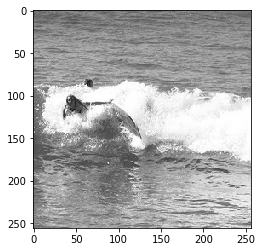

In [21]:
show('./img/bwColorizer.jpg')

#### Output

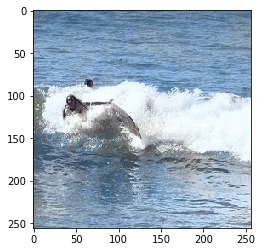

In [22]:
show("./img/outputColorizer.jpg")


#### Original

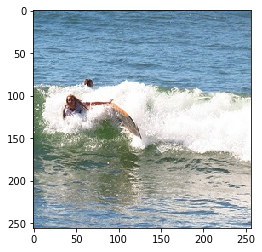

In [23]:
show('./img/inputColorizer.jpg')

## Full pipeline

In [24]:
# colorir e melhorar qualidade no mesmo fluxo
def colorize_and_enhance(img, weights_colorize, weights_enhance):
    colored = colorize(img, weights_colorize)
    enhance_colored = enhance(colored, weights_enhance)
    return enhance_colored

In [28]:
weights_colorize = "./models/model_colorize/cp-0010.ckpt"
weights_enhance = './models/model_enhance/'

image = cv2.imread('./img/inputColorizerEnhance.jpg')


result = colorize_and_enhance(image, weights_colorize, weights_enhance)

cv2.imwrite("./img/outputColorizerEnhance.jpg", result)

True

#### Input

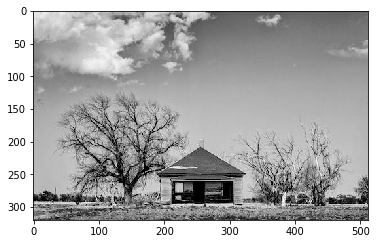

In [26]:
show("./img/inputColorizerEnhance.jpg")

#### Output

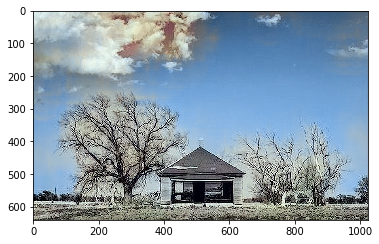

In [27]:
show("./img/outputColorizerEnhance.jpeg")